# Training Surrogates

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OJWatson/emidm/blob/main/examples/surrogate_notebook.ipynb)

In [ ]:
!git clone https://github.com/OJWatson/emidm.git
%cd emidm
!pip install .

In [40]:
# Imports from our own package
from emidm.sir import run_sir, run_model_with_replicates, plot_model_outputs
from emidm.sampler import generate_lhs_samples
import pandas as pd
from plotnine import ggplot, aes, geom_line, facet_wrap

In [41]:
# Demonstrate running one model
single = run_sir()

# Show the output
single

,t,N,S,I,R
0,0,1000,990,10,0
1,1,1000,984,16,0
2,2,1000,981,16,3
3,3,1000,977,16,7
4,4,1000,974,18,8
...,...,...,...,...,...
96,96,1000,223,16,761
97,97,1000,221,14,765
98,98,1000,220,14,766
99,99,1000,220,14,766


<Axes: xlabel='t'>

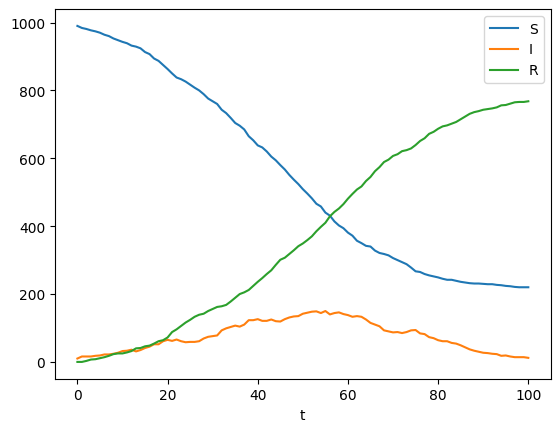

In [42]:
# Show a single plot line
single.plot("t", ["S", "I", "R"])


<Axes: xlabel='t'>

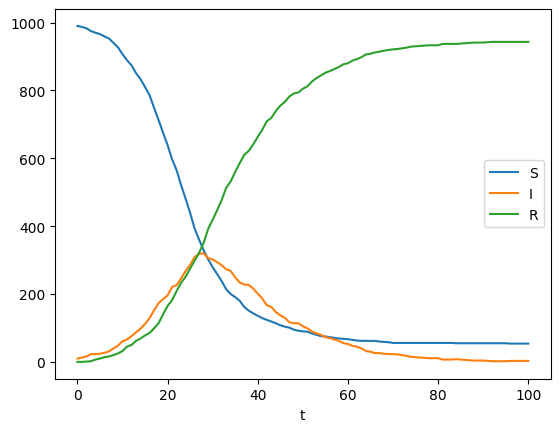

In [43]:
# We can also vary the parameters
alt = run_sir(beta = 0.3)
alt.plot("t", ["S", "I", "R"])

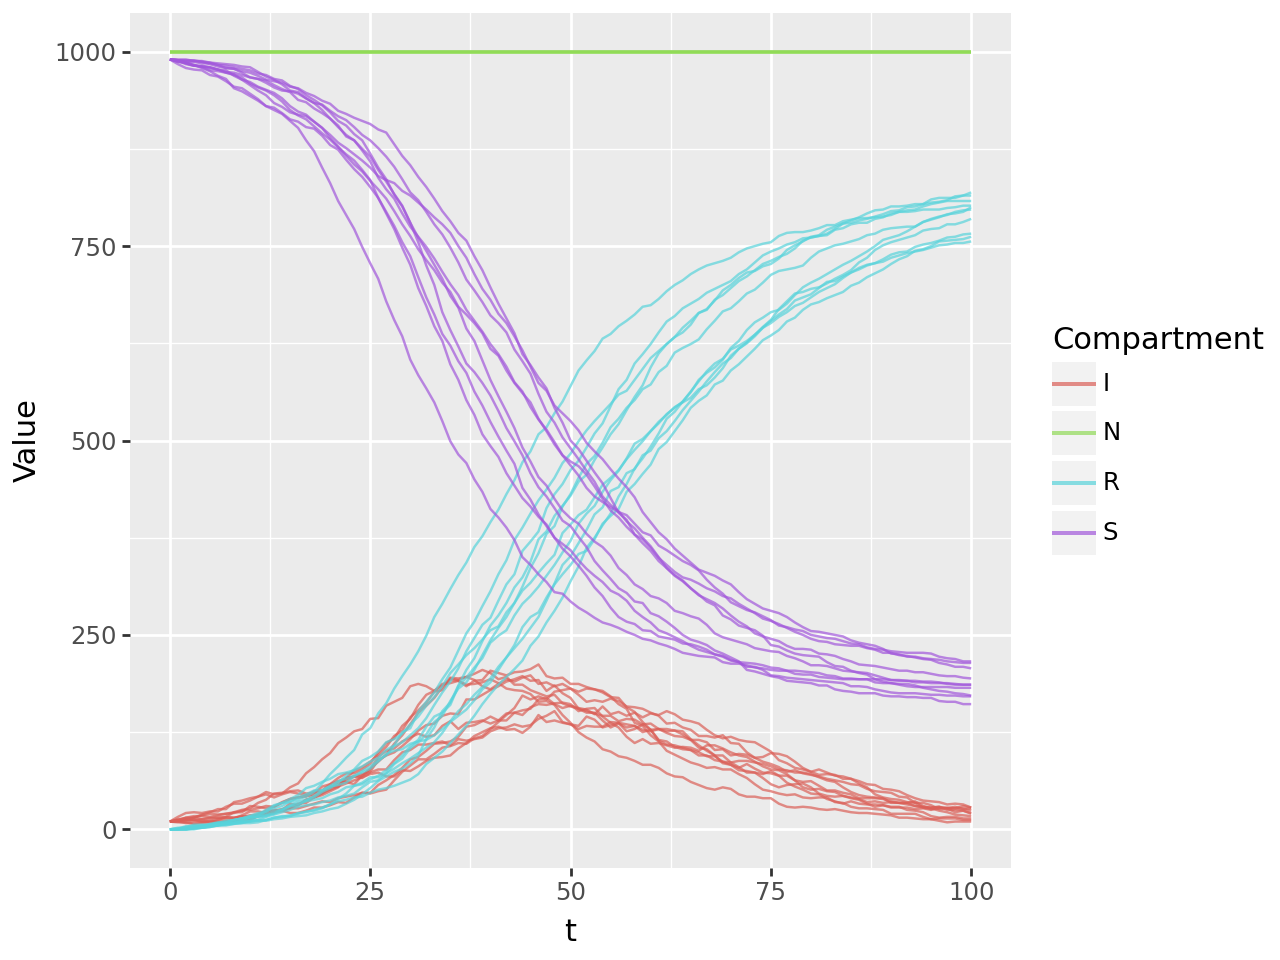

In [44]:
# we can run multiple realisations
reps = run_model_with_replicates(model = run_sir, reps = 10)

# and plot these
p = plot_model_outputs(reps)

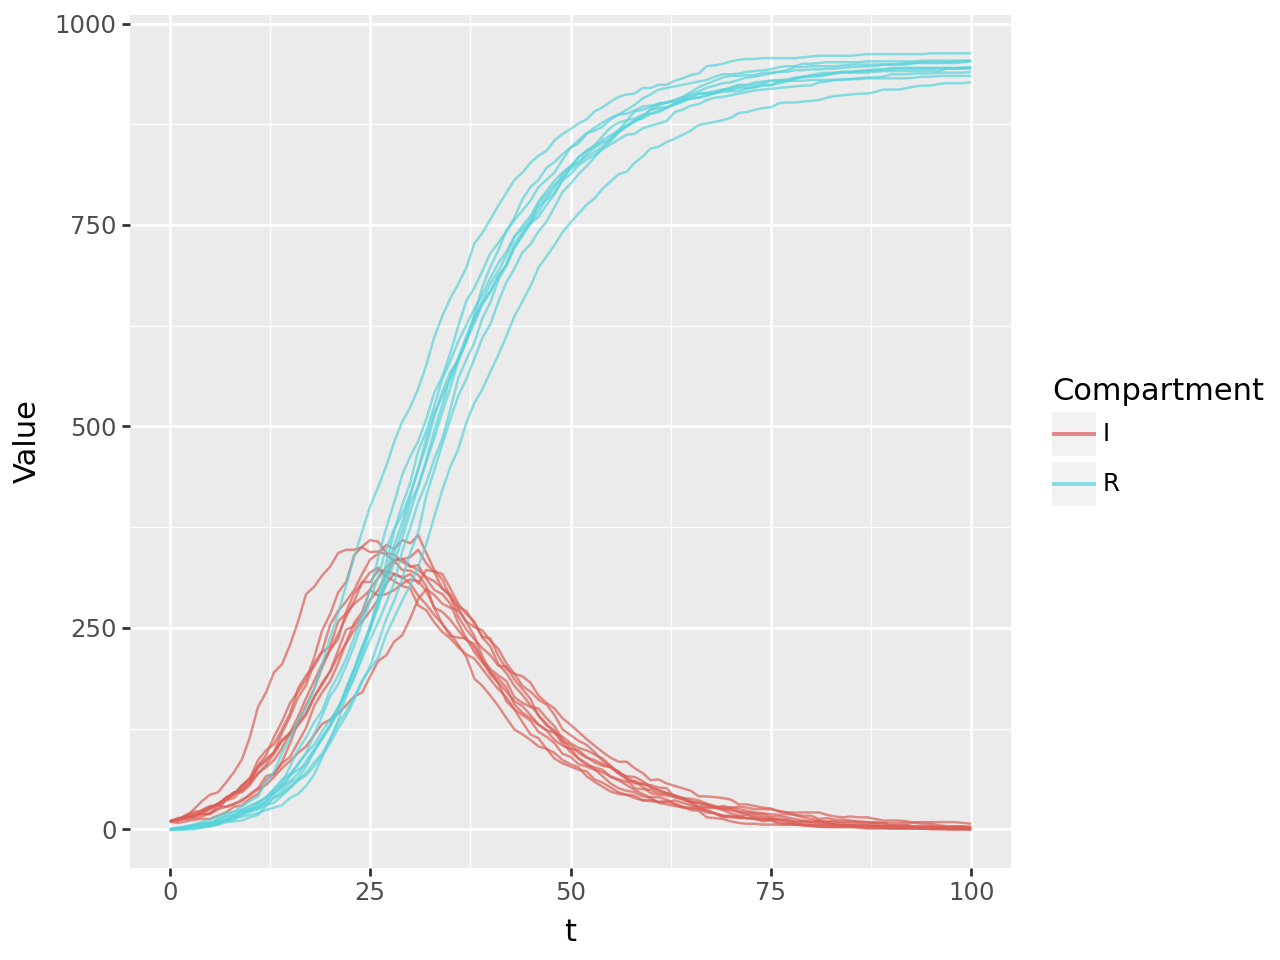

In [45]:
# we can also by args to run_sir through kwargs
reps = run_model_with_replicates(model=run_sir, reps=10, beta = 0.3)

# and plot these
p = plot_model_outputs(reps, columns = ["I", "R"])

In [46]:
# now to generate a lhs sample
param_ranges = {"beta": [0.1, 0.5], "gamma": [0.05, 0.5]}
df_samples = generate_lhs_samples(param_ranges, n_samples=9, seed=42)
df_samples

,beta,gamma
0,0.376713,0.228056
1,0.150729,0.165132
2,0.229148,0.351219
3,0.421727,0.310697
4,0.272084,0.127481
5,0.350187,0.253662
6,0.471384,0.458862
7,0.302515,0.088638
8,0.119796,0.446809


In [47]:
# Run the model for each row of samples:
results = [
    run_model_with_replicates(**row.to_dict(), reps=10).assign(**row.to_dict())
    for _, row in df_samples.iterrows()
]

# Combine results into one DataFrame:
df_all_results = pd.concat(results, axis=0)

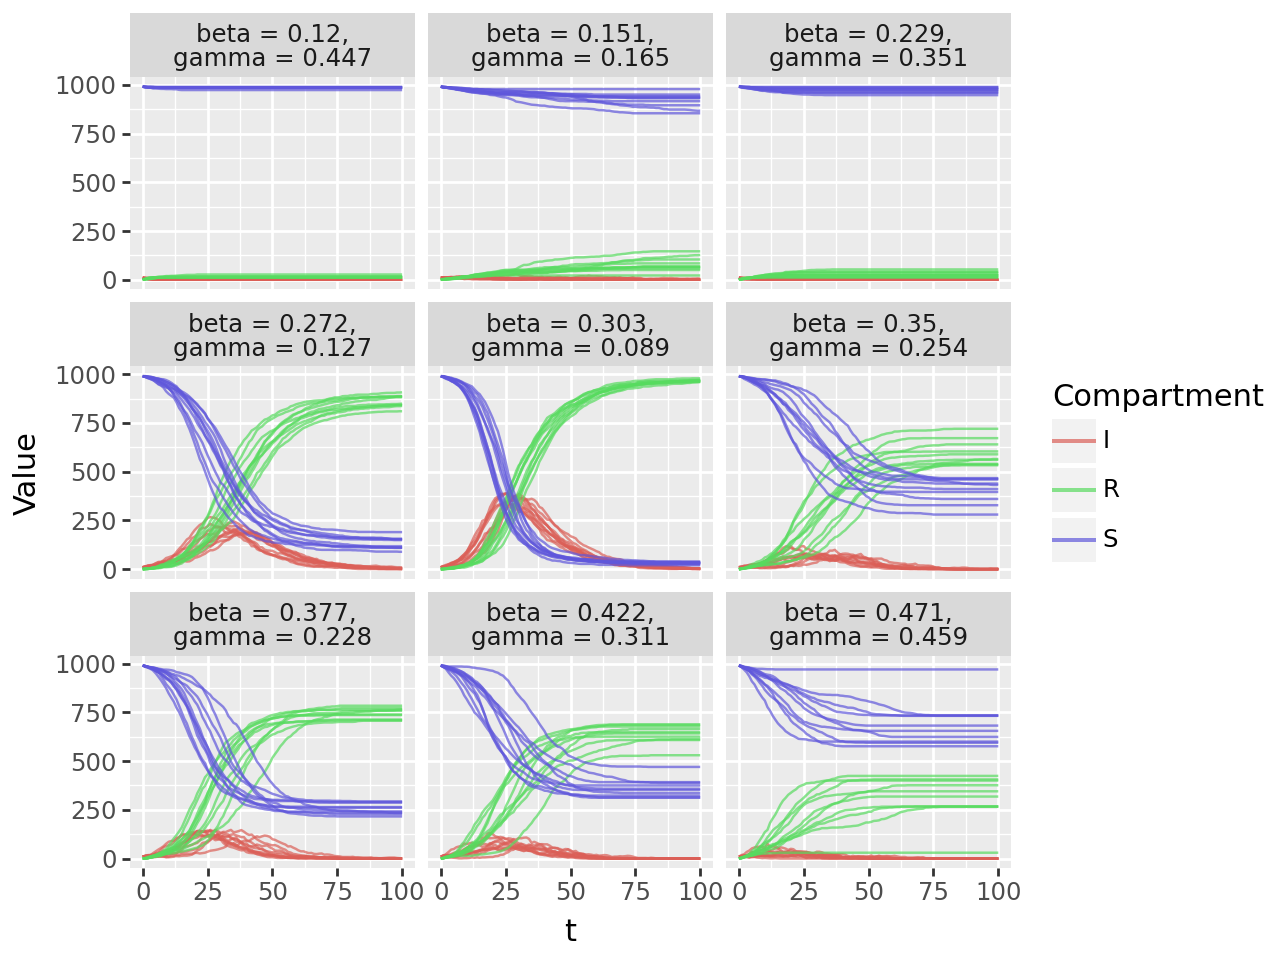

In [49]:
# Reshape dataframe into tidy long-format
df_long = df_all_results.melt(
    id_vars=["t", "replicate", "gamma", "beta"],
    value_vars=["S", "I", "R"],
    var_name="Compartment",
    value_name="Value",
)

# Add unique identifier for group plotting
df_long = df_long.assign(
    uid=df_long["Compartment"]
    + df_long["replicate"].astype(str)
)

# Add facet identifier for group plotting
df_long = df_long.assign(
    facet="beta = "
    + df_long["beta"].round(3).astype(str)
    + ",\n"
    + "gamma = "
    + df_long["gamma"].round(3).astype(str)
)

# Plot: color by compartment, lines grouped by replicate
p = (
    ggplot(
        df_long,
        aes(x="t", y="Value", group="uid", color="Compartment"),
    )
    + geom_line(alpha=0.7)
    + facet_wrap("facet")
)

# Explicitly plot
ggplot.show(p)